## Cassava Leaf Disease Classification models using ResNet50


### ResNet50

ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. It has 3.8 x 10^9 Floating points operations. It is a widely used ResNet model and we have explored ResNet50 architecture in depth.


[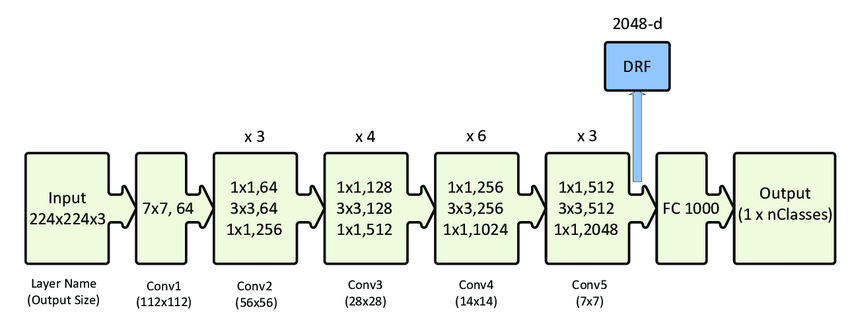](http://)




### Description

[train/test]_images the image files. The full set of test images will only be available to your notebook when it is submitted for scoring. Expect to see roughly 15,000 images in the test set.

train.csv

* image_id the image file name.

* label the ID code for the disease.

sample_submission.csv A properly formatted sample submission, given the disclosed test set content.

* image_id the image file name.

* label the predicted ID code for the disease.

#### Dataset:

[Link](https://www.kaggle.com/c/cassava-leaf-disease-classification/data)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import cv2
import os
import keras
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation,add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import DenseNet201
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet169
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomCrop, Rescaling, RandomTranslation
from keras import Sequential
from tqdm import tqdm
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
root_dir = '../input/cassava-leaf-disease-classification'

train_df = pd.read_csv(os.path.join(root_dir, 'train.csv'))
print("there are " + str(train_df.shape[0]) + " train samples" )
train_df.head()

In [ ]:
train_img_dir = os.path.join(root_dir, 'train_images')  

figure = plt.figure(figsize = (20,20))

cont = 0
    
for i in range(5):
    
    speci = train_df[train_df['label'] == i]
    
    for j in range(5):
        
        img = Image.open(os.path.join(train_img_dir, speci.iloc[j,0]))
        
        plt.subplot(5,5, cont+1)
        
        plt.imshow(img)
        
        cont = cont + 1

In [ ]:
image_preprocessor = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomCrop(150,150),
    RandomTranslation(0.3, 0.3),
    RandomRotation(0.5),
    Rescaling(1./255)])

def custom_gen(batch_size, image_dir, h = 150, w = 150):
    
    start = 0
    end = batch_size
    images = train_df['image_id']
    labels = train_df['label']
    while 1:
        
        if end >= train_df.shape[0]:
            start = 0
            end = batch_size 
            continue
        else:
        
            batch = []

            if start == 0:
                names = images[:end]
                y = to_categorical(labels[:end], num_classes = 5)
            else:
                names = images[start:end]
                y = to_categorical(labels[start:end], num_classes = 5)

            for name in names:

                img = cv2.imread(os.path.join(image_dir,name))
                img = np.expand_dims(img, axis = 0)
                img = image_preprocessor(img)
                img = np.squeeze(img, axis = 0)
                batch.append(img)



            end = end + batch_size
            start = start +  batch_size


            yield np.array(batch), y

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(150,150,3),include_top=False,weights="imagenet")

In [ ]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5, activation = 'softmax'))

In [ ]:
# Model Summary

model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.75, min_lr = 1e-4)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=2)

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

In [ ]:
batch_size = 64
epochs = 20
steps_per_epoch = train_df.shape[0] // batch_size
train_gen = custom_gen(batch_size, train_img_dir)
%time
history = model.fit(train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch,verbose = 1,callbacks=[lrd,mcp,es] )

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_leaf = "../input/cassava-leaf-disease-classification/test_images"

test_names = pd.Series(os.listdir(test_leaf))


for j in range(3):

    for i in tqdm(range(len(test_names))):

        image = cv2.imread(os.path.join(test_leaf, test_names[i]))
        image = np.expand_dims(image, axis = 0)
        image = image_preprocessor(image)
        if i ==0:

            pred = model.predict(image)
        else:
            pred = np.concatenate([pred, model.predict(image)])
            
    if j ==0:
        final = pred
    else:
        final = final +pred
     
pred = pd.Series(np.argmax(final, axis = 1))


test_df = pd.concat([test_names, pred], axis = 1)
test_df = test_df.rename(columns = {0: 'image_id', 1: 'label'})

test_df.to_csv('submission.csv', index = False)
